***

<font color='green'>

# Project Solution: Ensemble Techniques
### Filename: parkinsons.data (https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/)
### File consists of data for a range of biomedical voice measurements from 32 people, 24 with Parkinson's Disease (PD). There are 195 voice recordings from these patients
### Purpose: Build model that will help discriminate between a healthy patient vs a patient with PD based on signals of voice recordings - this may act as an effective screening step prior to an appointment with clinician  
***
***
*Prepared by: Sauvik De*

*Date: August 31, 2020*
    
</font>

***

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics

In [2]:
# Load voice recording data
# Note: The datafile 'parkinsons.data' is stored under the same folder as that of this ipynb notebook

vrPatientData = pd.read_csv('parkinsons.data', sep=',', header=0)

### Exploratory Data Analysis

In [3]:
print(f'The shape of the dataframe is {vrPatientData.shape}')
print('\nFirst few rows of the dataframe:')
vrPatientData.head()

The shape of the dataframe is (195, 24)

First few rows of the dataframe:


name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3  phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4  phon_R01_S01_5      116.014       141.781       110.655         0.01284   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
0           0.00007   0.00370   0.00554     0.01109       0.04374  ...   
1           0.00008   0.00465   0.00696     0.01394       0.06134  ...   
2           0.00009   0.00544   0.00781     0.01633       0.05233  ...   
3           0.00009   0.00502   0.00698     0.01505       0.05492  ...   
4           0.00011   0.00655   0.00908     0.01966       0.06425  ...   

   Shimmer:DDA      NHR     HNR  status      RPDE       DFA   spread1  \
0      0.06545  0.02211  21.033       1  0.414783  0.815285 -4.813031   
1      0.09403  0.01929  19.085       1  0.458359  0.819521 -4.075192   
2      0.08270  0.01309  20.651       1  0.429895  0.825288 -4.443179   
3      0.08771  0.01353  20.644       1  0.434969  0.819235 -4.117501   
4      0.10470  0.01767  19.649       1  0.417356  0.823484 -3.747787   

    spread2        D2       PPE  
0  0.266482  2.301442  0.284654  
1  0.335590  2.486855  0.368674  
2  0.311173  2.342259  0.332634  
3  0.334147  2.405554  0.368975  
4  0.234513  2.332180  0.410335  

[5 rows x 24 columns]

In [4]:
# Check columns and their datatypes

print("\nThere don't seem to be any missing values.\
 Column 'name' being voice recording identifier.\
 Column 'status' being a binary categorical column denoting whether the patient is healthy (0) or, with PD (1).\
 Rest of 22 columns pertain to signal data of voice recording and all of them are of float type.")

print('\n')
vrPatientData.info()


There don't seem to be any missing values. Column 'name' being voice recording identifier. Column 'status' being a binary categorical column denoting whether the patient is healthy (0) or, with PD (1). Rest of 22 columns pertain to signal data of voice recording and all of them are of float type.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
name                195 non-null object
MDVP:Fo(Hz)         195 non-null float64
MDVP:Fhi(Hz)        195 non-null float64
MDVP:Flo(Hz)        195 non-null float64
MDVP:Jitter(%)      195 non-null float64
MDVP:Jitter(Abs)    195 non-null float64
MDVP:RAP            195 non-null float64
MDVP:PPQ            195 non-null float64
Jitter:DDP          195 non-null float64
MDVP:Shimmer        195 non-null float64
MDVP:Shimmer(dB)    195 non-null float64
Shimmer:APQ3        195 non-null float64
Shimmer:APQ5        195 non-null float64
MDVP:APQ            195 non-null float64
Shimmer:DDA         1

In [5]:
# Count check of subjects of experiments in the dataset

print('\nTotal number of patients in the dataset:\
', vrPatientData['name'].apply(lambda n: n[:-2]).nunique())
print('Total number of PD patients in the dataset:\
', vrPatientData[vrPatientData['status']==1]['name'].apply(lambda n: n[:-2]).nunique())


Total number of patients in the dataset: 32
Total number of PD patients in the dataset: 24


In [6]:
# One likely challenge in the dataset ...

print("\nAs we have multiple records (6-7) per patient, the sampling design is a repeated measures design.\
 Hence the observations in the sample can't be considered independent. So parametric models having independence\
 of observations assumption may not work well with this data.\
 This may be one challenge in terms of limitation of usage of parametric models to this data.\
 However,  we have certain non-parametric models for predictive purpose like\
 decision tree, ensemble technique like random forest.\
 They can be utilized for modelling for this kind of data.")

print('\nThere are 29 patients with 6 voice recording samples for each, and 3 patients with 7 voice recording samples for each.')
tmp = vrPatientData['name'].apply(lambda n: n[:-2][-3:]).value_counts().value_counts()
pd.DataFrame({'Count of voice recordings per patient':tmp.index, 'Number of patients with voice recordings':tmp.values})


As we have multiple records (6-7) per patient, the sampling design is a repeated measures design. Hence the observations in the sample can't be considered independent. So parametric models having independence of observations assumption may not work well with this data. This may be one challenge in terms of limitation of usage of parametric models to this data. However,  we have certain non-parametric models for predictive purpose like decision tree, ensemble technique like random forest. They can be utilized for modelling for this kind of data.

There are 29 patients with 6 voice recording samples for each, and 3 patients with 7 voice recording samples for each.


Count of voice recordings per patient  \
0                                      6   
1                                      7   

   Number of patients with voice recordings  
0                                        29  
1                                         3

In [7]:
# Let's look at the distribution of response 'status' column

print('\nThere seems to have class imbalance in the data with count of positive cases more than three times\
 that of negative cases.')
print("\nCount of patients by medical status: [0: healthy patient, 1: patients with Parkinson's Disease (PD)]")
vrPatientData['status'].value_counts()


There seems to have class imbalance in the data with count of positive cases more than three times that of negative cases.

Count of patients by medical status: [0: healthy patient, 1: patients with Parkinson's Disease (PD)]


1    147
0     48
Name: status, dtype: int64

In [8]:
# Univariate analysis
# start with five-number summary and basic stats

print('\nLooking at the basic descriptive summary of attributes:')
print('1) MDVP:Fo, MDVP:Fhi, MDVP:Flo, HNR are certainly at a different scale versus others attributes.')
print('2) Both MDVP:Fhi and MDVP:Flo seem to have right skewed distribution, as mean exceeds median well for both of them;\
 while   MDVP:Fo has moderate right skewness.')
print('3) Among others, most of the variables are right skewed; while HNR, RPDE, DFA, spread2, D2 are moderately symmetric\
 as mean and median almost coincide.')
print('4) Next We can look at boxplot and histogram to get better sense of the distribution and outliers for the attributes.')
vrPatientData.drop(columns='status', axis=1, inplace=False).describe().T


Looking at the basic descriptive summary of attributes:
1) MDVP:Fo, MDVP:Fhi, MDVP:Flo, HNR are certainly at a different scale versus others attributes.
2) Both MDVP:Fhi and MDVP:Flo seem to have right skewed distribution, as mean exceeds median well for both of them; while   MDVP:Fo has moderate right skewness.
3) Among others, most of the variables are right skewed; while HNR, RPDE, DFA, spread2, D2 are moderately symmetric as mean and median almost coincide.
4) Next We can look at boxplot and histogram to get better sense of the distribution and outliers for the attributes.


count        mean        std         min         25%  \
MDVP:Fo(Hz)       195.0  154.228641  41.390065   88.333000  117.572000   
MDVP:Fhi(Hz)      195.0  197.104918  91.491548  102.145000  134.862500   
MDVP:Flo(Hz)      195.0  116.324631  43.521413   65.476000   84.291000   
MDVP:Jitter(%)    195.0    0.006220   0.004848    0.001680    0.003460   
MDVP:Jitter(Abs)  195.0    0.000044   0.000035    0.000007    0.000020   
MDVP:RAP          195.0    0.003306   0.002968    0.000680    0.001660   
MDVP:PPQ          195.0    0.003446   0.002759    0.000920    0.001860   
Jitter:DDP        195.0    0.009920   0.008903    0.002040    0.004985   
MDVP:Shimmer      195.0    0.029709   0.018857    0.009540    0.016505   
MDVP:Shimmer(dB)  195.0    0.282251   0.194877    0.085000    0.148500   
Shimmer:APQ3      195.0    0.015664   0.010153    0.004550    0.008245   
Shimmer:APQ5      195.0    0.017878   0.012024    0.005700    0.009580   
MDVP:APQ          195.0    0.024081   0.016947    0.007190    0.013080   
Shimmer:DDA       195.0    0.046993   0.030459    0.013640    0.024735   
NHR               195.0    0.024847   0.040418    0.000650    0.005925   
HNR               195.0   21.885974   4.425764    8.441000   19.198000   
RPDE              195.0    0.498536   0.103942    0.256570    0.421306   
DFA               195.0    0.718099   0.055336    0.574282    0.674758   
spread1           195.0   -5.684397   1.090208   -7.964984   -6.450096   
spread2           195.0    0.226510   0.083406    0.006274    0.174351   
D2                195.0    2.381826   0.382799    1.423287    2.099125   
PPE               195.0    0.206552   0.090119    0.044539    0.137451   

                         50%         75%         max  
MDVP:Fo(Hz)       148.790000  182.769000  260.105000  
MDVP:Fhi(Hz)      175.829000  224.205500  592.030000  
MDVP:Flo(Hz)      104.315000  140.018500  239.170000  
MDVP:Jitter(%)      0.004940    0.007365    0.033160  
MDVP:Jitter(Abs)    0.000030    0.000060    0.000260  
MDVP:RAP            0.002500    0.003835    0.021440  
MDVP:PPQ            0.002690    0.003955    0.019580  
Jitter:DDP          0.007490    0.011505    0.064330  
MDVP:Shimmer        0.022970    0.037885    0.119080  
MDVP:Shimmer(dB)    0.221000    0.350000    1.302000  
Shimmer:APQ3        0.012790    0.020265    0.056470  
Shimmer:APQ5        0.013470    0.022380    0.079400  
MDVP:APQ            0.018260    0.029400    0.137780  
Shimmer:DDA         0.038360    0.060795    0.169420  
NHR                 0.011660    0.025640    0.314820  
HNR                22.085000   25.075500   33.047000  
RPDE                0.495954    0.587562    0.685151  
DFA                 0.722254    0.761881    0.825288  
spread1            -5.720868   -5.046192   -2.434031  
spread2             0.218885    0.279234    0.450493  
D2                  2.361532    2.636456    3.671155  
PPE                 0.194052    0.252980    0.527367


From the boxplots of the attributes, below are a few findings:
1) There are several variables having their distribution highly right skewed with long tail, for e.g.:MDVP:Flo, MDVP:Jitter, MDVP:RAP, Jitter:DDP, MDVP:Shimmer, MDVP:APQ, NHR etc.
2) However, HNR, spread1, D2 seem to be symmetrically distributed.
3) NHR, MDVP:PPQ, MDVP:Jitter, Shimmer:APQ5 seem to be contain outliers.


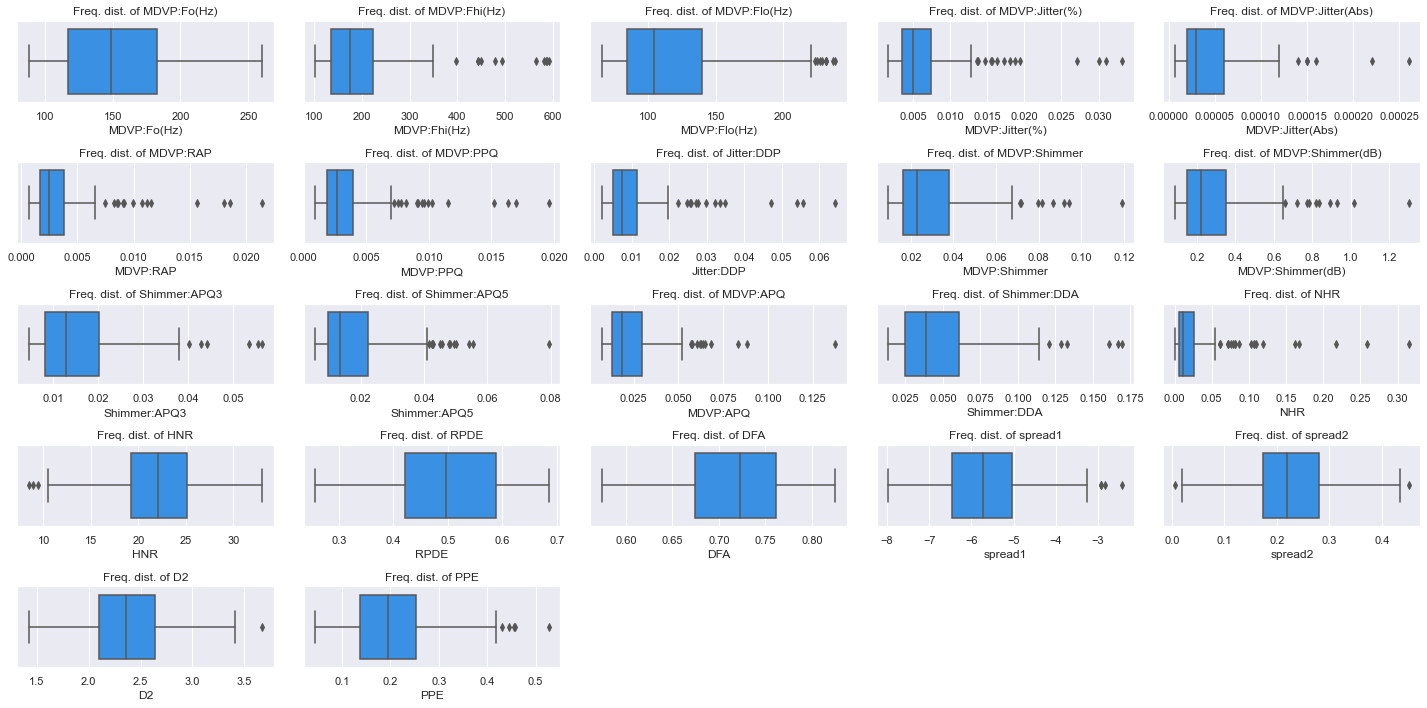

In [9]:
# Let's look at the distribution of each of the attributes in the dataset

print('\nFrom the boxplots of the attributes, below are a few findings:')
print('1) There are several variables having their distribution highly right skewed with long tail,\
 for e.g.:MDVP:Flo, MDVP:Jitter, MDVP:RAP, Jitter:DDP, MDVP:Shimmer, MDVP:APQ, NHR etc.')
print('2) However, HNR, spread1, D2 seem to be symmetrically distributed.')
print('3) NHR, MDVP:PPQ, MDVP:Jitter, Shimmer:APQ5 seem to be contain outliers.')

sns.set()
fig, ax = plt.subplots(5, 5, figsize=(40,25))
plt.gcf().set_size_inches(20, 10)

cols = vrPatientData.drop(labels=['name', 'status'], axis=1, inplace=False).columns

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        if (i*ax.shape[1]+j) <= (len(cols)-1):
            sns.boxplot(vrPatientData[cols[i*ax.shape[1]+j]], color='dodgerblue', ax=ax[i][j]).\
            set_title("Freq. dist. of {}".format(cols[i*ax.shape[1]+j]))
        else:
            fig.delaxes(ax=ax[i][j])

plt.tight_layout()


Looking at the pairplot of the attributes, there are some interesting findings:
1) HNR, RPDE, spread1, D2 and PPE seem to separate the status (i.e., patients with PD and without PD) bit clearly.
2) MDVP:Jitter(%), MDVP:Jitter(Abs), MDVP:RAP, MDVP:PPQ, Jitter:DDP, MDVP:Shimmer, MDVP:Shimmer(dB), Shimmer:APQ3, Shimmer:APQ5, MDVP:APQ, Shimmer:DDA, NHR, spread1 and PPE seem to be strongly correlated between each other.
3) Only HNR is strongly negatively correlated with all other attributes except for variables pertaining to vocal fundamental frequency (MDVP:Fo, MDVP:Fhi, MDVP:Flo).


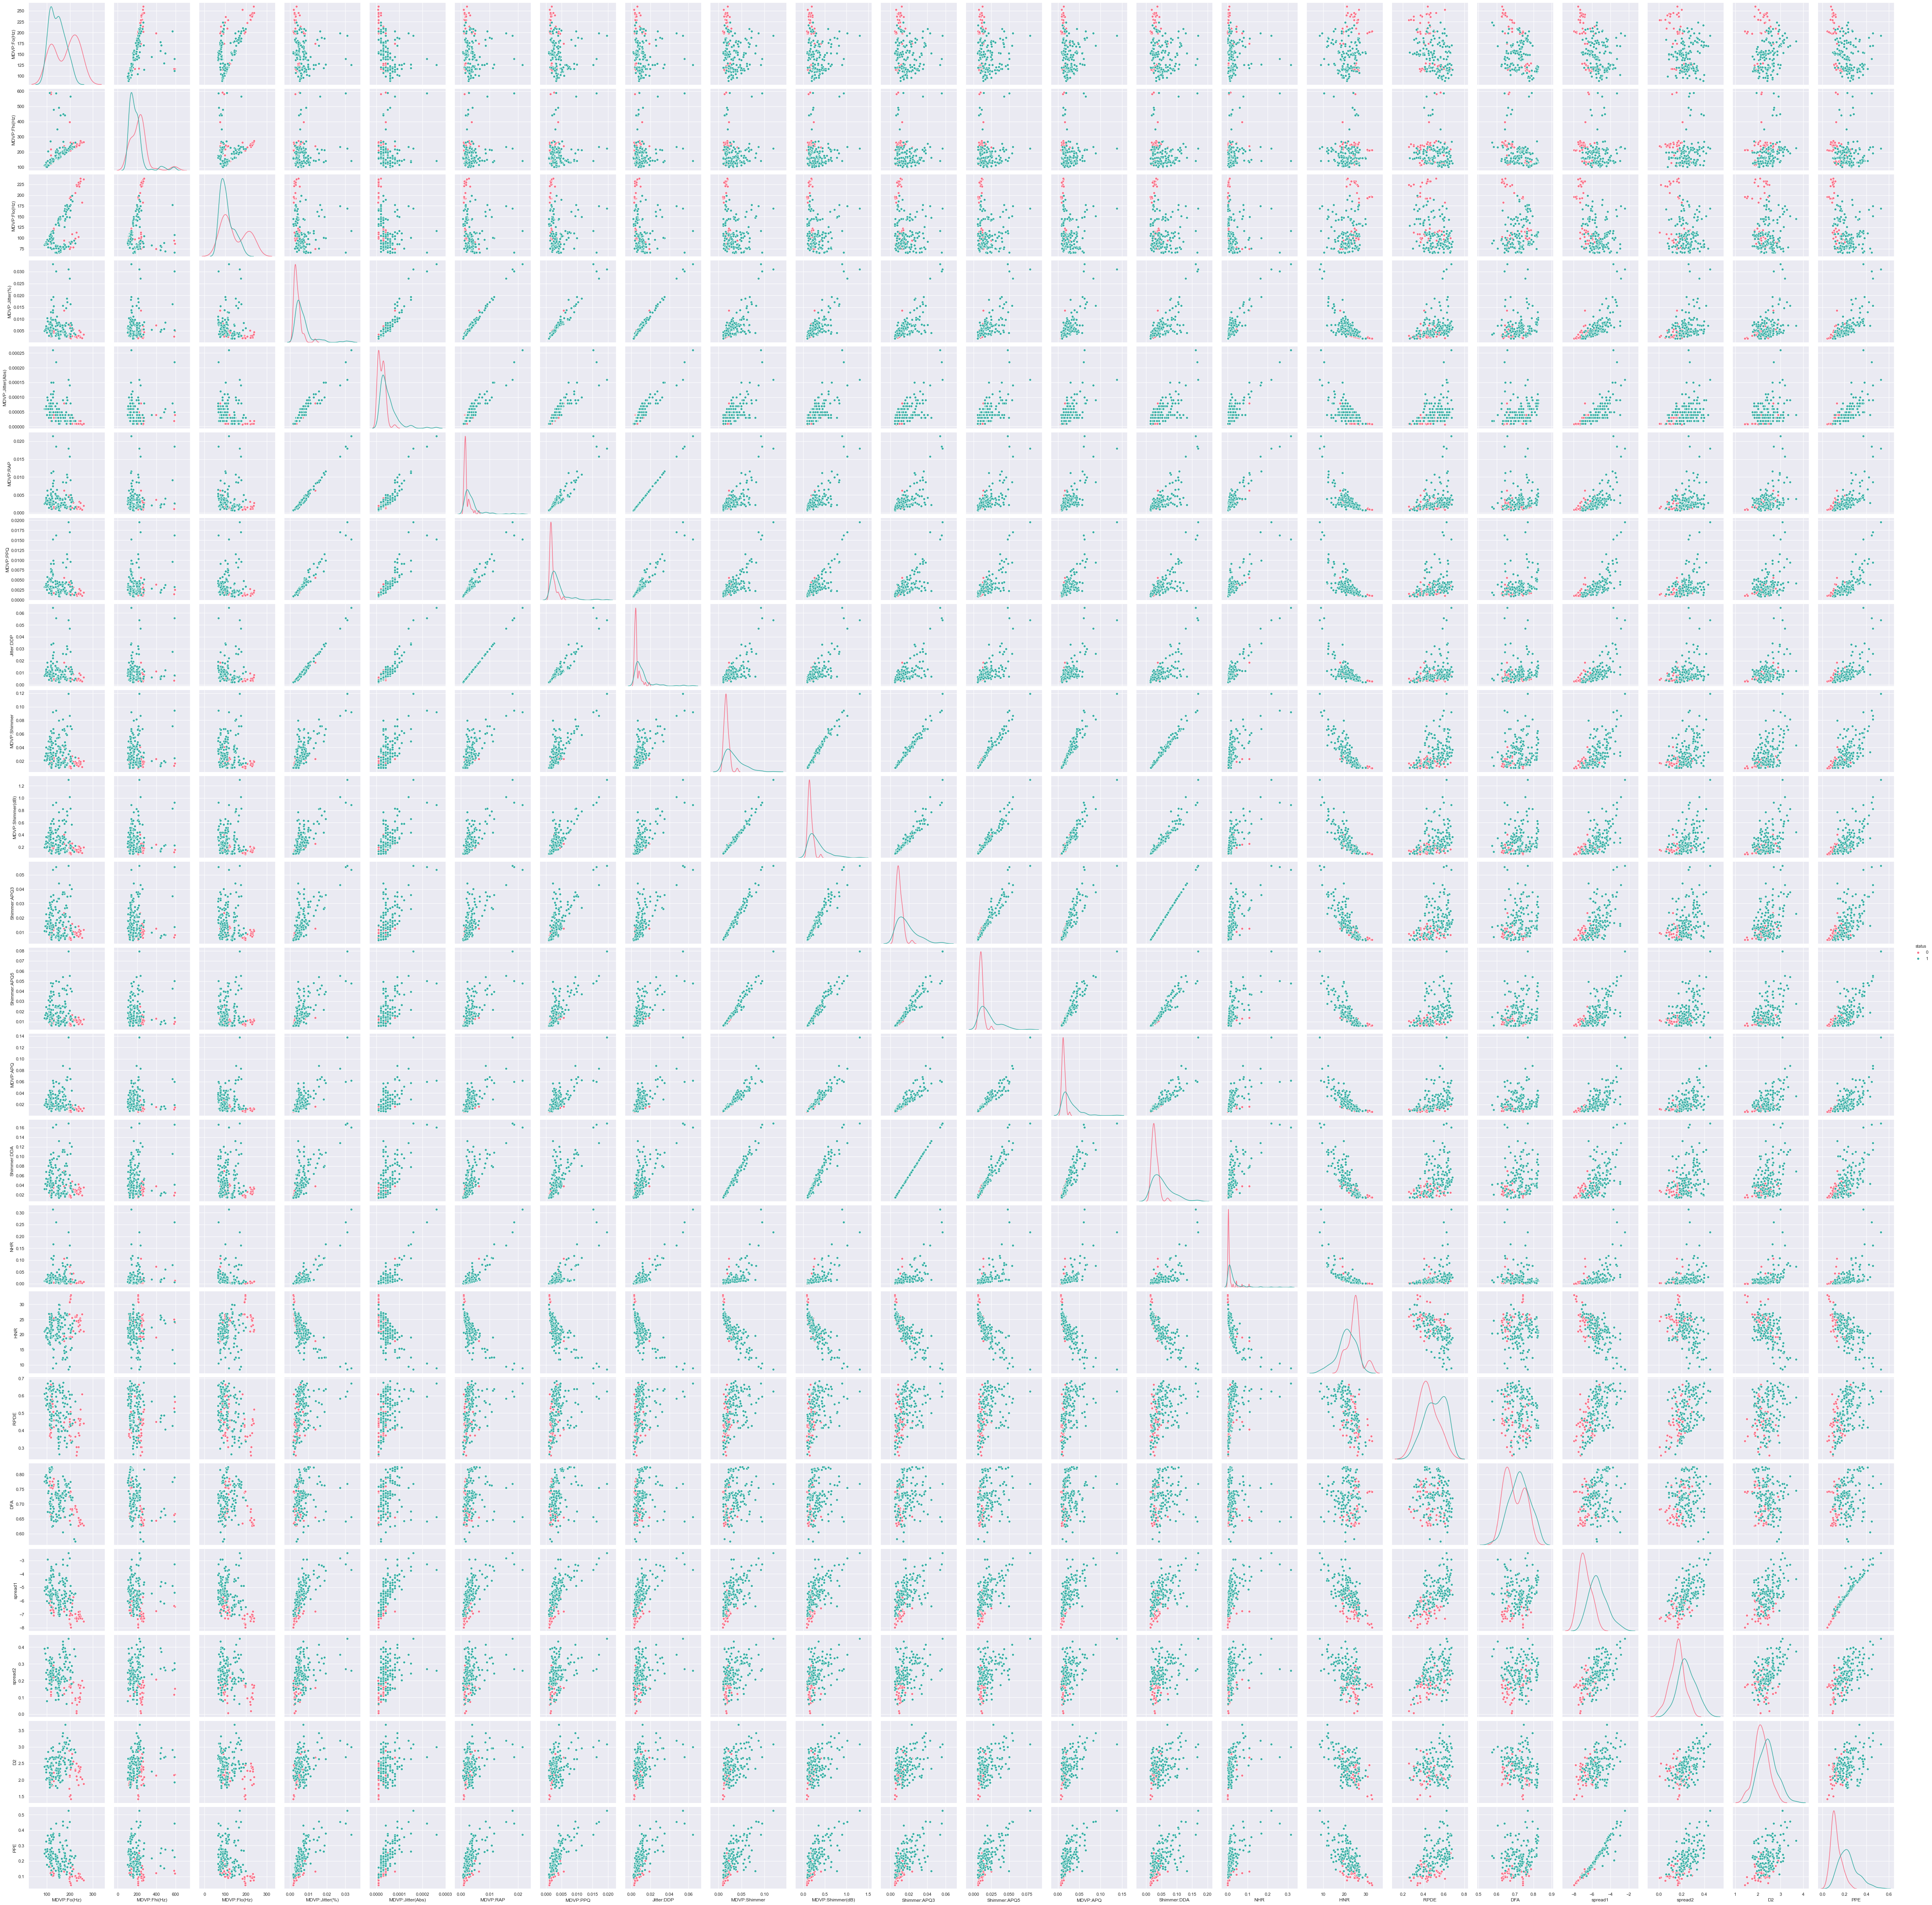

In [10]:
# Bivariate analysis
# Let's look at the attributes in a bi-variate way: 1) scatter plot, 2) correlation matrix
# The other likely challenge for any modelling work is again evident here. 
# It is visible that there is a clear presence of multicollinearity in the dataset
# Hence we can handle this problem by using principal component analysis
# or, by removing redundant features from paramteric models
# Alternatively, decision tree, or, ensemble techniques like random forest are robust enough to handle multicollinearity
# Hence those can also be applied on this data 

print('\nLooking at the pairplot of the attributes, there are some interesting findings:')
print('1) HNR, RPDE, spread1, D2 and PPE seem to separate the status (i.e., patients with PD and without PD) bit clearly.')
print('2) MDVP:Jitter(%), MDVP:Jitter(Abs), MDVP:RAP, MDVP:PPQ, Jitter:DDP, MDVP:Shimmer, MDVP:Shimmer(dB), Shimmer:APQ3,\
 Shimmer:APQ5, MDVP:APQ, Shimmer:DDA, NHR, spread1 and PPE seem to be strongly correlated between each other.')
print('3) Only HNR is strongly negatively correlated with all other attributes except for variables pertaining\
 to vocal fundamental frequency (MDVP:Fo, MDVP:Fhi, MDVP:Flo).')

_ = sns.pairplot(data=vrPatientData.drop(labels=['name'], axis=1, inplace=False), hue='status', diag_kind='kde',\
                 palette='husl', height=3, plot_kws={'edgecolor':'white'}, diag_kws={'shade':False})


The below correlation matrix confirms the above findings numerically.


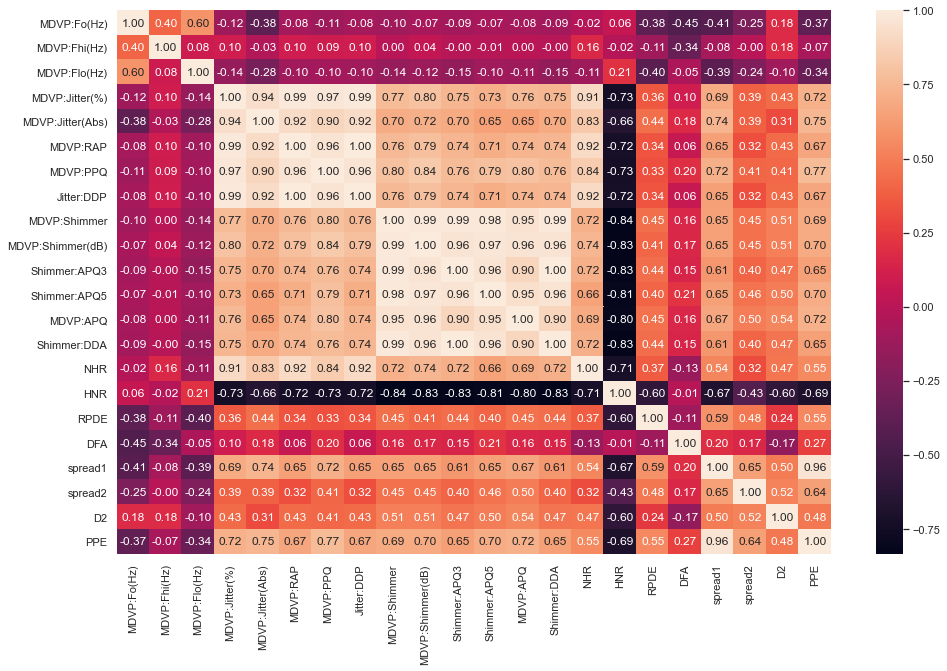

In [11]:
print('\nThe below correlation matrix confirms the above findings numerically.')

plt.figure(figsize=(16,10))
_ = sns.heatmap(vrPatientData.drop(labels=['name', 'status'], axis=1, inplace=False).corr(), annot=True, fmt='.2f')


Insights from the conditional boxplots of attributes:
1) Typically vocal fundamental frequency seems to be lower for positive PD patients vs healthy patients. Boxplot of MDVP:Flo(Hz) conditioned on medical status shows the same.
2) All the measures pertaining to the variation in fundamental frequency [MDVP:Jitter(%), MDVP:Jitter(Abs), MDVP:RAP, MDVP:PPQ, Jitter:DDP] are higher for positive PD patients vs healthy patients.
3) All the measure pertaining to the variation in amplitude [MDVP:Shimmer, MDVP:Shimmer(dB), Shimmer:APQ3, Shimmer:APQ5, MDVP:APQ, Shimmer:DDA] are also higher for positive PD patients vs healthy patients.
4) NHR, a meausre based on ratio of noise to tonal components in the voice, is higher for positive PD patients vs healthy patients.
5) HNR, another meausre based on ratio of noise to tonal components in the voice, is lower for positive PD patients vs healthy patients. This is likely an inverted measure of NHR.
6) RPDE and D2, the nonlinear dynamical complexity meas

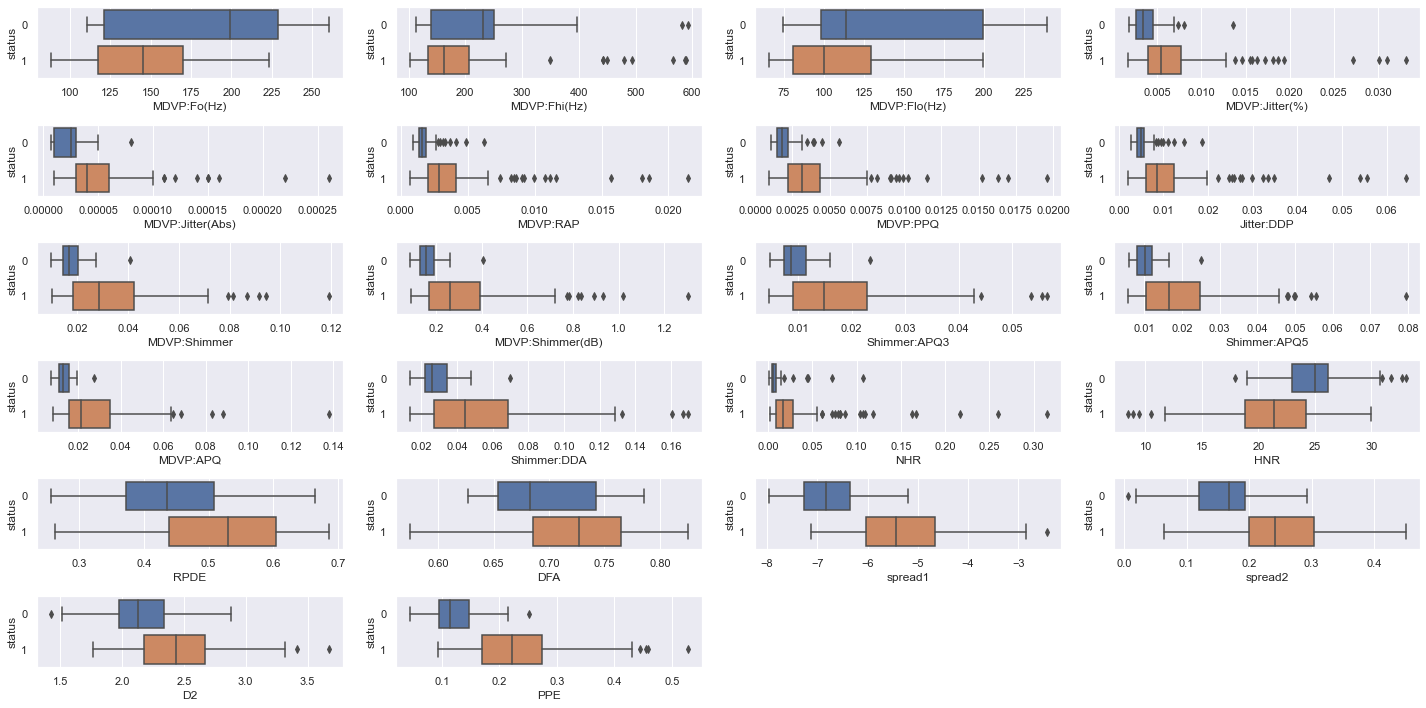

In [12]:
# Another way to look at the distribution of attributes conditioned on medical status

print('\nInsights from the conditional boxplots of attributes:')
print('1) Typically vocal fundamental frequency seems to be lower for positive PD patients vs healthy patients.\
 Boxplot of MDVP:Flo(Hz) conditioned on medical status shows the same.')
print('2) All the measures pertaining to the variation in fundamental frequency [MDVP:Jitter(%), MDVP:Jitter(Abs),\
 MDVP:RAP, MDVP:PPQ, Jitter:DDP] are higher for positive PD patients vs healthy patients.')
print('3) All the measure pertaining to the variation in amplitude [MDVP:Shimmer, MDVP:Shimmer(dB), Shimmer:APQ3,\
 Shimmer:APQ5, MDVP:APQ, Shimmer:DDA] are also higher for positive PD patients vs healthy patients.')
print('4) NHR, a meausre based on ratio of noise to tonal components in the voice, is higher\
 for positive PD patients vs healthy patients.')
print('5) HNR, another meausre based on ratio of noise to tonal components in the voice, is lower\
 for positive PD patients vs healthy patients. This is likely an inverted measure of NHR.')
print('6) RPDE and D2, the nonlinear dynamical complexity measures are typically higher\
 for positive PD patients vs healthy patients.')
print('7) spread1, spread2, and PPE, the nonlinear measures of fundamental frequency variation are distinguighably higher\
 for positive PD patients vs healthy patients.')
print('8) DFA, the signal fractal scaling exponent measure, is also higher for positive PD patients vs healthy patients.')


cols = vrPatientData.drop(labels=['name', 'status'], axis=1, inplace=False).columns

fig = plt.figure(figsize=(40,25))
fig.set_size_inches(20, 10)

for i in range(1, len(cols)+1):
    ax = fig.add_subplot(6, 4, i)
    g = sns.boxplot(x=cols[i-1], y='status', orient = 'h', data=vrPatientData, ax=ax)

plt.tight_layout()

### Partition data into Training and Test sets, Build model and evaluate performance

<font color='green'>

#### A few comments before we move on to model building exercise
1) This prediction problem is a classification problem.

2) We have multiple voice records (6-7) per patient. So the sampling design is a repeated measures design. Hence the observations in the sample can't be considered independent. So parametric models having independence of observations assumption may not work well with this data. This may be one challenge in terms of limitation of usage of parametric models.

3) The other challenge with the dataset is it does have the problem of multicollinearity. This should ideally be removed before proceeding with most parametric modelling and can be handled either by removing one redundant predictor, or, using PCA to combine variables.

4) There are a few outliers in the dataset and this can pose issue in parametric modelling. It can be handled either by removing it, or by replacing it using median or IQR capping.

5) Given the above points in mind, we can use Decision Tree, Ensemble techniques like Random Forest to model for prediction of PD patients using this dataset without feature engineering / transformation etc. Because these non-paramteric techniques are much robust to those challenges.
    
<font>

In [13]:
# Prepare reponse and predictor datasets
y = vrPatientData['status']
X = vrPatientData.drop(columns = ['name', 'status'], axis=1, inplace=False)

In [14]:
# Split dataset into train and test sets (in 70:30 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print('Shape of training set for features (X):', X_train.shape)
print('Shape of test set for features (X):', X_test.shape)
print('Shape of training set for target (y):', y_train.shape)
print('Shape of test set for target (y):', y_test.shape)

Shape of training set for features (X): (136, 22)
Shape of test set for features (X): (59, 22)
Shape of training set for target (y): (136,)
Shape of test set for target (y): (59,)


In [15]:
# Let's start with Decision Tree with impurity calc criteria as Entropy
# Since the dataset size is not big (only 195 records), we can expect Entropy to perform better over Gini,
# As Entropy tends to work better for smaller data with multiple categories
# and, given that we have all the predictors continuous, we may expect multiple binning to evaluate the node impurity 

# Starting with decision tree without regularization
baseDT = DecisionTreeClassifier(criterion='entropy', random_state=1)

# Fit the decision tree model to the training data
baseDT.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=1)


Training set accuracy score (Decision Tree): 1.0
Test set accuracy score (Decision Tree): 0.864406779661017
This is a case of over-fitting as expected. We can regularize / prune the decision tree to make it better.

The depth of the unregularized tree: 4

Classification report for Decision Tree based model using Test dataset:
              precision    recall  f1-score   support

           0       0.92      0.63      0.75        19
           1       0.85      0.97      0.91        40

    accuracy                           0.86        59
   macro avg       0.89      0.80      0.83        59
weighted avg       0.87      0.86      0.86        59



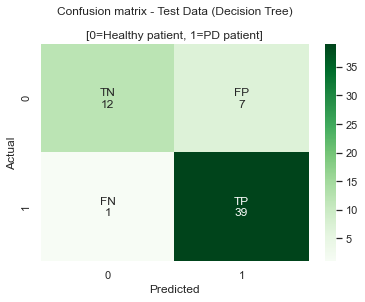

In [16]:
# Evaluate the accuracy, recall, and precision of the unregularized decision tree model on Test dataset
# Also, capture the predicted values and cross-tab of actual vs predicted using confusion matrix

# alternative way to calc accuracy score: Test accuracy score = baseDT.score(X_test, y_test)
print("\nTraining set accuracy score (Decision Tree):", metrics.accuracy_score(y_train, baseDT.predict(X_train)))
print("Test set accuracy score (Decision Tree):", metrics.accuracy_score(y_test, baseDT.predict(X_test)))
print('This is a case of over-fitting as expected. We can regularize / prune the decision tree to make it better.')

print('\nThe depth of the unregularized tree:', baseDT.get_depth())

print('\nClassification report for Decision Tree based model using Test dataset:')
print(metrics.classification_report(y_test, baseDT.predict(X_test)))

cm_dt = metrics.confusion_matrix(y_test, baseDT.predict(X_test))
lbl_dt = [f"{i}\n{j}" for i, j in zip(['TN', 'FP', 'FN', 'TP'], cm_dt.flatten())]
_ = sns.heatmap(cm_dt, annot=np.asarray(lbl_dt).reshape(2,2), fmt='', cmap='Greens').\
 set_title('Confusion matrix - Test Data (Decision Tree)\n\n[0=Healthy patient, 1=PD patient]')
_ = plt.xlabel('Predicted')
_ = plt.ylabel('Actual')

#### From the result above, the following points may be noted:
1) Decision tree tends to overfit without regularization with training accuracy being 100% vs test accuracy being 86%.

2) The recall for positive PD cases is of utmost importance in healthcare industry, especially in this context. The recall for PD class is 97% on test dataset with only 1 out of 40 "actual" positive PD cases in test set being misclassified by the decision tree model. In my opinion, the unregularized decision tree performed great indeed on test set in terms of recall score for positive cases.

3) F1-score for positive PD cases on test dataset is 91%. However, the precision for positive PD cases (85% with 7 false positives) is not great.

4) Although we have certainly achieved good recall on test data for positive PD cases, the overall accuracy needs improvement to make it "generally" better. So we can try regularization to avoid overfitting of decision tree, and make it perform better all round.

In [17]:
# Decision tree with regularization
# Important hyperparameters for tree pruning: max_depth, min_samples_leaf, min_samples_split, max_features
# Evaluate the accuracy, recall, and precision of the regularized decision tree model on Test dataset
# Since it is a small dataset, we focus on max_depth and min_samples_leaf for tuning
# ********************************************************************************************************

# Note: The unregularized tree had max depth of 4 (since sample size is not big). We are not left with much choices.
# Hence to prune it, we can try smaller values of max_depth. Let's use max_depth = 2,3

# Note: min_samples_leaf is always guaranteed; while min_samples_split is dependent on min_samples_leaf
# Hence to avoid overfitting, we can try higher values of min_samples_leaf
# given the sample sizes for training and test sets being 136 and 59 respectively, we can try min_samples_leaf = 2,3,4

# ********************************************************************************************************
# Quick utility function to avoid repetitive codes
def printResults(mdl):
    # Fit model to the training data
    mdl.fit(X_train, y_train)

    print("\nPruned Decision Tree with Max Depth = ", 'Unrestricted' if mdl.max_depth == None else mdl.max_depth,\
          " and Min Samples Leaf = ", "Default 1" if mdl.min_samples_leaf == 1 else mdl.min_samples_leaf, ":", sep='')

    # Evaluate model on test dataset
    print(f"Training accuracy: {metrics.accuracy_score(y_train, mdl.predict(X_train)):.2%}\
 & Test accuracy: {metrics.accuracy_score(y_test, mdl.predict(X_test)):.2%}")

    print(f"Test set recall score for positive PD class: {metrics.recall_score(y_test, mdl.predict(X_test)):.2%}")
    print(f"Test set F1-score for positive PD class: {metrics.f1_score(y_test, mdl.predict(X_test)):.2%}")
# ********************************************************************************************************

# case 1: max_depth = 2
printResults(DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=1))

# case 2: max_depth = 3
printResults(DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1))

# case 3: min_samples_leaf = 2
printResults(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2, random_state=1))

# case 4: min_samples_leaf = 3
printResults(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=3, random_state=1))

# case 5: min_samples_leaf = 4
printResults(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=4, random_state=1))


Pruned Decision Tree with Max Depth = 2 and Min Samples Leaf = Default 1:
Training accuracy: 89.71% & Test accuracy: 79.66%
Test set recall score for positive PD class: 100.00%
Test set F1-score for positive PD class: 86.96%

Pruned Decision Tree with Max Depth = 3 and Min Samples Leaf = Default 1:
Training accuracy: 97.79% & Test accuracy: 89.83%
Test set recall score for positive PD class: 95.00%
Test set F1-score for positive PD class: 92.68%

Pruned Decision Tree with Max Depth = Unrestricted and Min Samples Leaf = 2:
Training accuracy: 98.53% & Test accuracy: 89.83%
Test set recall score for positive PD class: 97.50%
Test set F1-score for positive PD class: 92.86%

Pruned Decision Tree with Max Depth = Unrestricted and Min Samples Leaf = 3:
Training accuracy: 97.79% & Test accuracy: 88.14%
Test set recall score for positive PD class: 97.50%
Test set F1-score for positive PD class: 91.76%

Pruned Decision Tree with Max Depth = Unrestricted and Min Samples Leaf = 4:
Training accura

#### From the above results, below are a few insights:
1) max_depth = 2 gives 100% test recall score for positive PD class; however, the overall test accuracy goes down, and there is a presence of overfitting. From the industry perspective this choice may be a lucrative one due to recall being most important metric.

2) max_depth = 3 is better than max_depth = 2 in terms of overall accuracy.

3) Both min_samples_leaf = 2 and min_samples_leaf = 4 give very similar result and also overall best result. In terms of model simiplicity, we can select min_samples_leaf = 4 between the two.

In [18]:
# We can also try Grid Search CV to pick the best hyperparameter combination.
# This is bit more robust as stratified k-fold cross-validation for each hyperparameter combination is performed.

# excluded max_depth = 4 since we already found this is an overfit model
# excluded min_samples_leaf = 1 as this is the most unrestricted option for tree formation
# goal: trying to find a sweet spot where both recall score and overall accuracy score are optimal

params = {'max_depth': [2,3],
          'min_samples_leaf': range(2,6),
          'random_state':[1]}

bestDT1 = GridSearchCV(DecisionTreeClassifier(criterion='entropy'), param_grid=params, cv=5, scoring='recall', n_jobs=-1)
bestDT1.fit(X_train, y_train)
print("\nBest Decision Tree model using recall score criterion:")
print(pd.DataFrame(bestDT1.cv_results_['params'])[bestDT1.cv_results_['rank_test_score']==1]) #bestDT1.best_params_

#cv1 = cross_validate(bestDT1.best_estimator_, X=X_train, y=y_train, scoring=['accuracy', 'recall', 'precision'], cv=10, n_jobs=-1)
#print('Overall Accuracy: Mean =', cv1['test_accuracy'].mean(), 'and SD =', cv1['test_accuracy'].std())
#print('Recall score: Mean =', cv1['test_recall'].mean(), 'and SD =', cv1['test_recall'].std())
#print('Precision score: Mean =', cv1['test_precision'].mean(), 'and SD =', cv1['test_precision'].std())

bestDT2 = GridSearchCV(DecisionTreeClassifier(criterion='entropy'), param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
bestDT2.fit(X_train, y_train)
print("\nBest Decision Tree model using overall accuracy score criterion:")
print(pd.DataFrame(bestDT2.cv_results_['params'])[bestDT2.cv_results_['rank_test_score']==1]) #bestDT2.best_params_

#cv2 = cross_validate(bestDT2.best_estimator_, X=X_train, y=y_train, scoring=['accuracy', 'recall', 'precision'], cv=10, n_jobs=-1)
#print('Overall Accuracy: Mean =', cv2['test_accuracy'].mean(), 'and SD =', cv2['test_accuracy'].std())
#print('Recall score: Mean =', cv2['test_recall'].mean(), 'and SD =', cv2['test_recall'].std())
#print('Precision score: Mean =', cv2['test_precision'].mean(), 'and SD =', cv2['test_precision'].std())


Best Decision Tree model using recall score criterion:
   max_depth  min_samples_leaf  random_state
0          2                 2             1
1          2                 3             1
2          2                 4             1
3          2                 5             1

Best Decision Tree model using overall accuracy score criterion:
   max_depth  min_samples_leaf  random_state
4          3                 2             1


#### Looking at the Grid Search results using CV = 5:
1) We evaluated the hyperparameter combination based on both recall and accuracy scores to understand how different the best models are.

2) The best model based on accuracy score criterion is the model with max_depth = 3 and min_samples_leaf = 2.

3) The best model based on recall score criterion is the model with max_depth = 2. As found earlier, this one gets us 100% recall score on test dataset at the cost of overall accuracy. 


Result for the best decision tree model in terms of overall test accuracy:
***************************************************************************
Regularized Decision Tree with max_depth = 3 and min_samples_leaf = 2 :

Training set accuracy score: 0.9705882352941176
Test set accuracy score: 0.8983050847457628

Classification report on Test dataset:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        19
           1       0.90      0.95      0.93        40

    accuracy                           0.90        59
   macro avg       0.89      0.87      0.88        59
weighted avg       0.90      0.90      0.90        59



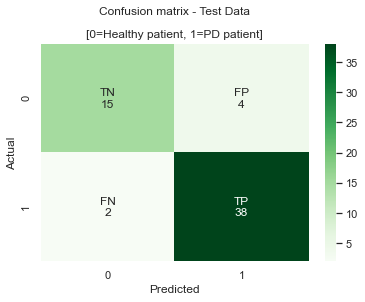

In [19]:
# Evaluate the test accuracy, recall, and precision of the best selected regularized decision tree model
# Also, capture the predicted values and cross-tab of actual vs predicted using confusion matrix

print('\nResult for the best decision tree model in terms of overall test accuracy:')
print('*'*75)
bestDT = bestDT2.best_estimator_
bestDT.fit(X_train, y_train)

print('Regularized Decision Tree with max_depth =', bestDT.get_depth(), 'and min_samples_leaf =', bestDT.min_samples_leaf, ':')
print("\nTraining set accuracy score:", metrics.accuracy_score(y_train, bestDT.predict(X_train)))
print("Test set accuracy score:", metrics.accuracy_score(y_test, bestDT.predict(X_test)))

print('\nClassification report on Test dataset:')
print(metrics.classification_report(y_test, bestDT.predict(X_test)))

cm_dt = metrics.confusion_matrix(y_test, bestDT.predict(X_test))
lbl_dt = [f"{i}\n{j}" for i, j in zip(['TN', 'FP', 'FN', 'TP'], cm_dt.flatten())]
_ = sns.heatmap(cm_dt, annot=np.asarray(lbl_dt).reshape(2,2), fmt='', cmap='Greens').\
 set_title('Confusion matrix - Test Data\n\n[0=Healthy patient, 1=PD patient]')
_ = plt.xlabel('Predicted')
_ = plt.ylabel('Actual')

#### From the result above, the following points may be noted:
1) With regularization, decision tree certainly tends to perform better with overall accuracy for test set increasing from ~86% to ~90%, mainly driven by the improvement in classification of the negative PD (i.e., healthy patient) class. Regularization can save a model from being overfit - this is evident from the output where the test accuracy improved (also, the delta between testing and training accuracy diminished).

2) The recall for positive PD class is 95% on test dataset with 2 out of 40 "actual" positive PD cases in test set being misclassified by the decision tree model. The unregularized decision tree performed better over the regularized model here on the test dataset in terms of recall score for positive cases. But in my opinion, it would have been certainly more interesting had we had more data to assess model performance. Moreover, decision tree performance is random in nature driven by random_state parameter. 

3) F1-score for positive PD status class on test dataset is an improvement over unregularized model (~95% vs ~91%). This is purely driven by the improvement in precision score for positive PD class.

4) It would be interesting to see how ensemble of decision trees works on this small dataset. So let's try with Random Forest.


Result for Random Forest model:

Training set accuracy score: 1.0
Test set accuracy score: 0.8305084745762712
The model is again an overfit since no regularization or, hyper-parameter tuning was performed.

Out-of-bag score: 0.9117647058823529

Classification report on Test dataset:
              precision    recall  f1-score   support

           0       0.91      0.53      0.67        19
           1       0.81      0.97      0.89        40

    accuracy                           0.83        59
   macro avg       0.86      0.75      0.78        59
weighted avg       0.84      0.83      0.82        59



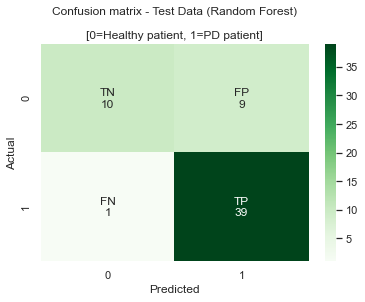

In [20]:
# Starting with Random Forest model ...

rf = RandomForestClassifier(criterion='entropy', oob_score=True, random_state=1)
rf.fit(X_train, y_train)

# Evaluate the accuracy, recall, and precision of the best selected regularized decision tree model on Test dataset

print('\nResult for Random Forest model:')
print("\nTraining set accuracy score:", metrics.accuracy_score(y_train, rf.predict(X_train)))
print("Test set accuracy score:", metrics.accuracy_score(y_test, rf.predict(X_test)))
print('The model is again an overfit since no regularization or, hyper-parameter tuning was performed.')

print('\nOut-of-bag score:', rf.oob_score_)

print('\nClassification report on Test dataset:')
print(metrics.classification_report(y_test, rf.predict(X_test)))

cm_rf = metrics.confusion_matrix(y_test, rf.predict(X_test))
lbl_rf = [f"{i}\n{j}" for i, j in zip(['TN', 'FP', 'FN', 'TP'], cm_rf.flatten())]
_ = sns.heatmap(cm_rf, annot=np.asarray(lbl_rf).reshape(2,2), fmt='', cmap='Greens').\
 set_title('Confusion matrix - Test Data (Random Forest)\n\n[0=Healthy patient, 1=PD patient]')
_ = plt.xlabel('Predicted')
_ = plt.ylabel('Actual')

#### From the result above, a few quick notes:
1) Without hyperparameter tuning, the random forest did overfit with training accuracy of 100% while test accuracy being 83%.

2) The recall for PD class is 97% on test dataset with only 1 out of 40 "actual" positive PD cases in test set being misclassified by the random forest model. In my opinion, the unregularized random forest performed great indeed on test set in terms of recall score for positive cases.

3) F1-score for positive PD cases on test dataset is 89%. However, the precision for positive PD cases (81% with 9 false positives) is not great.

4) Also, the recall score for negative PD class (i.e., for healthy patients) is only 53% and very poor.

5) Although we have certainly achieved good recall on test data for positive PD cases, the overall accuracy needs improvement to make it "generally" better. So we can try regularization to avoid overfitting of random forest, and make it perform better all round.

In [21]:
# Let's try hyperparameter tuning using Grid Search CV for Random Forest model
# We can try the same range for max_depth and min_samples_leaf as before (i.e., decision tree)
# In addition, we added variations in n_estimators and max_features
# In general, higher n_estimators is better as there will more voter trees contributing in prediction
# max_features should not be too high or too low as we want individual decision trees to be strong yet uncorrelated
# Since there are 22 features, we can take max_features between sqrt(22)=5 and 22/2=11

params = {'n_estimators': [11,51,101,151,201],
          'max_depth': [2,3],
          'min_samples_leaf': range(2,6),
          'max_features': range(5,11),
          'random_state': [1]}

bestRF = GridSearchCV(RandomForestClassifier(criterion='entropy'), param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
bestRF.fit(X_train, y_train)

print("\nBest Random Forest model based on overall accuracy score:")
print(pd.DataFrame(bestRF.cv_results_['params'])[bestRF.cv_results_['rank_test_score']==1])

print('\nBest average accuracy score:', bestRF.best_score_)


Best Random Forest model based on overall accuracy score:
     max_depth  max_features  min_samples_leaf  n_estimators  random_state
177          3             7                 5           101             1
193          3             8                 4           151             1

Best average accuracy score: 0.9198412698412698


#### Looking at the Grid Search results using CV = 5:
1) We evaluated the hyperparameter combination based on accuracy score and found two sets to be optimum in terms of best accuracy score.

2) Both of them look very similar in terms of hyperparameter contraints except that one is using more trees vs the other for prediction (151 vs 101).

3) Both of them can be expected to perform very similarly. We can evaluate their accuracy on test data and compare.


Result for the best random forest model in terms of overall test accuracy:
***************************************************************************
Regularized Random Forest with No. of trees= 101 , Max depth= 3 , Max Features= 7 , Min Samples Leaf= 5

Training set accuracy score: 0.9485294117647058
Test set accuracy score: 0.8305084745762712

Out-of-bag score: 0.875

Classification report on Test dataset:
              precision    recall  f1-score   support

           0       0.91      0.53      0.67        19
           1       0.81      0.97      0.89        40

    accuracy                           0.83        59
   macro avg       0.86      0.75      0.78        59
weighted avg       0.84      0.83      0.82        59



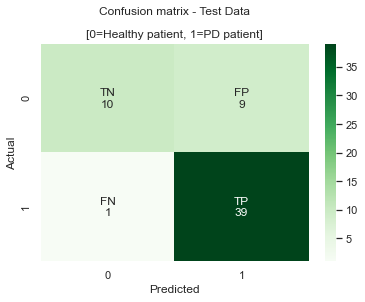



***************************************************************************
Regularized Random Forest with No. of trees= 151 , Max depth= 3 , Max Features= 8 , Min Samples Leaf= 4

Training set accuracy score: 0.9485294117647058
Test set accuracy score: 0.847457627118644

Out-of-bag score: 0.8823529411764706

Classification report on Test dataset:
              precision    recall  f1-score   support

           0       0.92      0.58      0.71        19
           1       0.83      0.97      0.90        40

    accuracy                           0.85        59
   macro avg       0.87      0.78      0.80        59
weighted avg       0.86      0.85      0.84        59



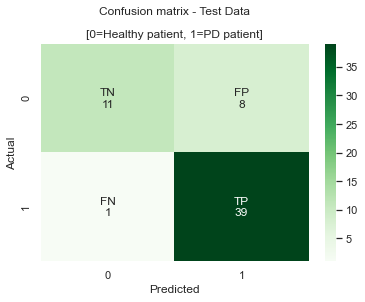

In [22]:
# Evaluate the test accuracy, recall, and precision of the best selected regularized random forest model
# Also, capture the predicted values and cross-tab of actual vs predicted using confusion matrix

# Utility function to print accuracy output of regularized Random Forest models
def printAccuracyRF(mdl):
    mdl.fit(X_train, y_train)

    print('Regularized Random Forest with No. of trees=', mdl.n_estimators, ', Max depth=', mdl.max_depth, ', Max Features=',\
          mdl.max_features, ', Min Samples Leaf=', mdl.min_samples_leaf)
    print("\nTraining set accuracy score:", metrics.accuracy_score(y_train, mdl.predict(X_train)))
    print("Test set accuracy score:", metrics.accuracy_score(y_test, mdl.predict(X_test)))

    print('\nOut-of-bag score:', mdl.oob_score_)
    
    print('\nClassification report on Test dataset:')
    print(metrics.classification_report(y_test, mdl.predict(X_test)))

    cm_dt = metrics.confusion_matrix(y_test, mdl.predict(X_test))
    lbl_dt = [f"{i}\n{j}" for i, j in zip(['TN', 'FP', 'FN', 'TP'], cm_dt.flatten())]
    g = sns.heatmap(cm_dt, annot=np.asarray(lbl_dt).reshape(2,2), fmt='', cmap='Greens').\
     set_title('Confusion matrix - Test Data\n\n[0=Healthy patient, 1=PD patient]')
    g = plt.xlabel('Predicted')
    g = plt.ylabel('Actual')
    plt.show()
#********************************************************************************************

print('\nResult for the best random forest model in terms of overall test accuracy:')
print('*'*75)

bestRF1 = RandomForestClassifier(n_estimators=101, max_depth=3, max_features=7, min_samples_leaf=5, criterion='entropy', oob_score=True, random_state=1)
printAccuracyRF(bestRF1)

print('\n')
print('*'*75)
bestRF2 = RandomForestClassifier(n_estimators=151, max_depth=3, max_features=8, min_samples_leaf=4, criterion='entropy', oob_score=True, random_state=1)
printAccuracyRF(bestRF2)

#### Below a few notes based on the result above:
1) The hyperparameter set [No. of estimators=151, Max depth=3, Max Features=8, Min Samples Leaf=4] is marginally better on test dataset between the two best models found by grid search CV method of hyperparameter tuning.

2) I would prefer to have more data for a better evaluation of this model. However, given the data at hand, the best random forest model has an overall test accuracy score of 85%, recall of 97% for positive PD class, F1-score of 90% for positive PD class.

3) However, notably the model performs poorly on recall score for negative PD class (i.e., healthy patients) as there 8 false potivies out of 19 "actual" healthy patients. This may be due to the fact that the dataset has majority of positive PD patients with few healthy cases. And, hence model is unable to learn "well" the healthy patients.

#### Conclusion
1) Decision Tree and Random Trees methods are great tools for classification when there are challenges with data quality like dependency among observations, presence of correlation between multiple pairs of features, non-normal (right skewed) distribution in dataset with potential outliers etc., since they don't assume underlying data distribution (i.e., non-parametric).

2) Dataset being very small, the degrees of freedom in terms of hyperparamter tuning is little (for e.g.: overfit attained at max_depth = 4).

3) Decision Tree model is a winner for PD prediction using this dataset versus Random Forest. The best model (in terms of overall accuracy) being the one with hyperparameters: max_depth=3, min_samples_leaf=2.

## <center><font color='green'>*******End of Project Solution*******</font></center>